# Probability of Default Model using ValidMind

- Step 1: Connect Notebook to ValidMind Project
- Step 2: Import Raw Data
- Step 3: Data Description on Raw Data
- Step 4: Data Preprocessing
- Step 5: Data Description on Preprocessed Data 
- Step 6: Univariate Analysis
- Step 7: Multivariate Analysis

## Step 1: Connect Notebook to ValidMind Project

#### Import Libraries

In [1]:
# Load API key and secret from environment variables
%load_ext dotenv
%dotenv .env

import zipfile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
%matplotlib inline

#### Connect Notebook to ValidMind Project

In [2]:
import validmind as vm

vm.init(
  api_host = "http://localhost:3000/api/v1/tracking",
  api_key = "2494c3838f48efe590d531bfe225d90b",
  api_secret = "4f692f8161f128414fef542cab2a4e74834c75d01b3a8e088a1834f2afcfe838",
  project = "cliwzqjgv00001fy6869rlav9"
)

2023-06-15 13:49:25,611 - INFO - api_client - Connected to ValidMind. Project: [3] PD Model - Initial Validation (cliwzqjgv00001fy6869rlav9)


## Step 2: Import Raw Data

#### Import Lending Club Dataset

In [3]:
# Specify the path to the zip file
# filepath = '/Users/juanvalidmind/Dev/datasets/lending club/data_2007_2014/loan_data_2007_2014.csv'
filepath = '/Users/juanvalidmind/Dev/datasets/lending club/data_2007_2011/lending_club_loan_data_2007_2011.csv'
df = pd.read_csv(filepath)

# ONLY FOR TESTING


# Perform operations on the DataFrame as needed
print(df.head())

        id  member_id  loan_amnt  funded_amnt  funded_amnt_inv        term  \
0  1077501    1296599       5000         5000           4975.0   36 months   
1  1077430    1314167       2500         2500           2500.0   60 months   
2  1077175    1313524       2400         2400           2400.0   36 months   
3  1076863    1277178      10000        10000          10000.0   36 months   
4  1075358    1311748       3000         3000           3000.0   60 months   

  int_rate  installment grade sub_grade  ... num_tl_90g_dpd_24m  \
0   10.65%       162.87     B        B2  ...                NaN   
1   15.27%        59.83     C        C4  ...                NaN   
2   15.96%        84.33     C        C5  ...                NaN   
3   13.49%       339.31     C        C1  ...                NaN   
4   12.69%        67.79     B        B5  ...                NaN   

  num_tl_op_past_12m pct_tl_nvr_dlq  percent_bc_gt_75 pub_rec_bankruptcies  \
0                NaN            NaN               

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/1935247548.py:4: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)


## Step 3: Data Description on Raw Data

In [4]:
from validmind.vm_models.test_context import TestContext
from validmind.data_validation.metrics import TabularDescriptionTables

vm_df = vm.init_dataset(dataset=df)
test_context = TestContext(dataset=vm_df)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-15 13:49:26,034 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-15 13:49:26,034 - INFO - dataset - Inferring dataset types...


## Step 4: Data Preparation

#### Remove Unused Variables

Remove all the **Demographic** and **Customer Behavioural** features which is of no use for default analysis for credit approval.

In [5]:
# remove non-required columns
# id - not required
# member_id - not required
# acc_now_delinq - empty
# funded_amnt - not useful, funded_amnt_inv is useful which is funded to person
# emp_title - brand names not useful
# pymnt_plan - fixed value as n for all
# url - not useful
# desc - can be applied some NLP but not for EDA
# title - too many distinct values not useful
# zip_code - complete zip is not available
# delinq_2yrs - post approval feature
# mths_since_last_delinq - only half values are there, not much information
# mths_since_last_record - only 10% values are there
# revol_bal - post/behavioural feature
# initial_list_status - fixed value as f for all
# out_prncp - post approval feature
# out_prncp_inv - not useful as its for investors
# total_pymnt - post approval feature
# total_pymnt_inv - not useful as it is for investors
# total_rec_prncp - post approval feature
# total_rec_int - post approval feature
# total_rec_late_fee - post approval feature
# recoveries - post approval feature
# collection_recovery_fee - post approval feature
# last_pymnt_d - post approval feature
# last_credit_pull_d - irrelevant for approval
# last_pymnt_amnt - post feature
# next_pymnt_d - post feature
# collections_12_mths_ex_med - only 1 value 
# policy_code - only 1 value
# acc_now_delinq - single valued
# application_type - single
# pub_rec_bankruptcies - single valued for more than 99%
# addr_state - may not depend on location as its in financial domain

unused_variables = ["id", "member_id", "funded_amnt", "emp_title", "pymnt_plan", "url", "desc",
                    "title", "zip_code", "delinq_2yrs", "mths_since_last_delinq", "mths_since_last_record",
                    "revol_bal", "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
                    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee", "recoveries",
                    "collection_recovery_fee", "last_pymnt_d", "last_pymnt_amnt", "next_pymnt_d", "last_credit_pull_d",
                    "collections_12_mths_ex_med", "policy_code", "acc_now_delinq", "application_type", "addr_state"]
df_selected_vars = df.drop(columns=unused_variables)
print("Features we are left with",list(df_selected_vars.columns))

Features we are left with ['loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 'num_accts_

In [6]:
df_selected_vars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   loan_amnt                       39717 non-null  int64  
 1   funded_amnt_inv                 39717 non-null  float64
 2   term                            39717 non-null  object 
 3   int_rate                        39717 non-null  object 
 4   installment                     39717 non-null  float64
 5   grade                           39717 non-null  object 
 6   sub_grade                       39717 non-null  object 
 7   emp_length                      38642 non-null  object 
 8   home_ownership                  39717 non-null  object 
 9   annual_inc                      39717 non-null  float64
 10  verification_status             39717 non-null  object 
 11  issue_d                         39717 non-null  object 
 12  loan_status                     

#### Process `emp_length`

In [7]:
def process_emp_length(df, column='emp_length'):
    # Define a mapping from original string values to numeric values
    mapping = {'10+ years': 10, '< 1 year': 0, '1 year': 1, '2 years': 2, 
               '3 years': 3, '4 years': 4, '5 years': 5, '6 years': 6, 
               '7 years': 7, '8 years': 8, '9 years': 9, np.nan: np.nan}
    
    # Apply the mapping to the specified column
    df[column] = df[column].map(mapping)
    return df

In [8]:
df_selected_vars = process_emp_length(df_selected_vars, 'emp_length')

#### Format Dates

In [9]:
def convert_to_datetime(df, columns):
    # Specify the date format
    date_format = "%b-%y"

    # Iterate over the specified columns and convert to datetime
    for column in columns:
        df[column] = pd.to_datetime(df[column], format=date_format)

    return df

In [10]:
# Convert the specified columns to datetime
columns_to_convert = ['issue_d']
df_dates_fixed = convert_to_datetime(df_selected_vars, columns_to_convert)

#### Remove Variables with Large Number of Missing Values

In [11]:
def variables_with_min_missing(df, min_missing_percentage):
    # Calculate the percentage of missing values in each column
    missing_percentages = df.isnull().mean() * 100

    # Get the variables where the percentage of missing values is greater than the specified minimum
    variables_to_drop = missing_percentages[missing_percentages > min_missing_percentage].index.tolist()

    return variables_to_drop


In [12]:
min_missing_count = 80
variables_to_drop = variables_with_min_missing(df_dates_fixed, min_missing_count)
df_no_missing = df_dates_fixed.drop(columns=variables_to_drop)

#### Remove Missing Values

In [13]:
df_no_missing.dropna(axis=0, subset=["emp_length"], inplace=True)
df_no_missing.dropna(axis=0, subset=["revol_util"], inplace=True)

#### Remove Rows with Loan Status `Current` 

Removing records with loan status as **`Current`**, as the loan is currently running and we can’t infer any information regarding default from such loans.

In [14]:
# Remove the rows with loan_status as "Current"
df_no_current = df_no_missing[df_no_missing["loan_status"].apply(lambda x: False if x == "Current" else True)]

# Update loan_status as Fully Paid to 0 and Charged Off to 1
df_no_current["loan_status"] = df_no_current["loan_status"].apply(lambda x: 0 if x == "Fully Paid" else 1)

# Convert 'emp_length' to string type
df_no_current["emp_length"] = df_no_current["emp_length"].astype(str)

# Update emp_length feature with continuous values as int
# where (< 1 year) is assumed as 0 and 10+ years is assumed as 10 and rest are stored as their magnitude
df_no_current["emp_length"] = pd.to_numeric(df_no_current["emp_length"].apply(lambda x: 0 if "<" in x else (x.split('+')[0] if "+" in x else x.split()[0])))

# Look through the purpose value counts
loan_purpose_values = df_no_current["purpose"].value_counts() * 100 / df_no_current.shape[0]

# Remove rows with less than 1% of value counts in particular purpose 
loan_purpose_delete = loan_purpose_values[loan_purpose_values < 1].index.values
df_processed = df_no_current[[False if p in loan_purpose_delete else True for p in df_no_current["purpose"]]]

# Update int_rate, revol_util without % sign and as numeric type
df_processed["int_rate"] = pd.to_numeric(df_processed["int_rate"].apply(lambda x:x.split('%')[0]))
df_processed["revol_util"] = pd.to_numeric(df_processed["revol_util"].apply(lambda x:x.split('%')[0]))


/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/2483498336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_current["loan_status"] = df_no_current["loan_status"].apply(lambda x: 0 if x == "Fully Paid" else 1)
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/2483498336.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_current["emp_length"] = df_no_current["emp_length"].astype(str)
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/2483498336.py:

#### Add New Variables

In [15]:
# Extracting month and year from issue_date
df_processed['month'] = df_processed['issue_d'].apply(lambda x: x.month)
df_processed['year'] = df_processed['issue_d'].apply(lambda x: x.year)

# Get year from issue_d and replace the same
df_processed["earliest_cr_line"] = pd.to_numeric(df_processed["earliest_cr_line"].apply(lambda x:x.split('-')[1]))

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/1973576522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['month'] = df_processed['issue_d'].apply(lambda x: x.month)
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/1973576522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['year'] = df_processed['issue_d'].apply(lambda x: x.year)
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/1973576522.py:6: SettingWithCopyWarning: 
A val

#### Binning Continuous Variables

Create bins for `loan_amnt`.

In [16]:
# Create bins for loan_amnt range
bins = [0, 5000, 10000, 15000, 20000, 25000, 36000]
bucket_l = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000-25000','25000+']
df_processed['loan_amnt_range'] = pd.cut(df_processed['loan_amnt'], bins, labels=bucket_l)

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/3822866426.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['loan_amnt_range'] = pd.cut(df_processed['loan_amnt'], bins, labels=bucket_l)


Create bins for `int_rate` range.

In [17]:
# Convert 'int_rate' to numeric
df_processed['int_rate'] = pd.to_numeric(df_processed['int_rate'], errors='coerce')

# Create bins for int_rate range
bins = [0, 7.5, 10, 12.5, 15, 100]
bucket_l = ['0-7.5', '7.5-10', '10-12.5', '12.5-15', '15+']

# Using pd.cut to create 'int_rate_range' column
df_processed['int_rate_range'] = pd.cut(df_processed['int_rate'], bins, labels=bucket_l)

# Convert NaN to 'Unknown'
df_processed['int_rate_range'] = df_processed['int_rate_range'].cat.add_categories('Unknown')
df_processed['int_rate_range'].fillna('Unknown', inplace=True)

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/2728908669.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['int_rate'] = pd.to_numeric(df_processed['int_rate'], errors='coerce')
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/2728908669.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['int_rate_range'] = pd.cut(df_processed['int_rate'], bins, labels=bucket_l)
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/2728908669.py:12: 

Create bins for `annual_inc` range.

In [18]:
# Create bins for annual_inc range
bins = [0, 25000, 50000, 75000, 100000, 1000000]
bucket_l = ['0-25000', '25000-50000', '50000-75000', '75000-100000', '100000+']
df_processed['annual_inc_range'] = pd.cut(df_processed['annual_inc'], bins, labels=bucket_l)

# Convert NaN to 'Unknown'
df_processed['annual_inc_range'] = df_processed['annual_inc_range'].cat.add_categories('Unknown')
df_processed['annual_inc_range'].fillna('Unknown', inplace=True)

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/1298211290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['annual_inc_range'] = pd.cut(df_processed['annual_inc'], bins, labels=bucket_l)
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/1298211290.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['annual_inc_range'] = df_processed['annual_inc_range'].cat.add_categories('Unknown')
/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/

Create bins for `installment` range.

In [19]:
# Create bins for installment range
def installment(n):
    if n <= 200:
        return 'low'
    elif n > 200 and n <=500:
        return 'medium'
    elif n > 500 and n <=800:
        return 'high'
    else:
        return 'very high'

df_processed['installment'] = df_processed['installment'].apply(lambda x: installment(x))

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/3139974546.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['installment'] = df_processed['installment'].apply(lambda x: installment(x))


Create bins for `dti` range.

In [20]:
# Create bins for dti range
bins = [-1, 5.00, 10.00, 15.00, 20.00, 25.00, 50.00]
bucket_l = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25%+']
df_processed['dti_range'] = pd.cut(df_processed['dti'], bins, labels=bucket_l)

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/2593972862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['dti_range'] = pd.cut(df_processed['dti'], bins, labels=bucket_l)


## Step 5: Data Description on Processed Data

In [21]:
vm_df = vm.init_dataset(dataset=df_processed)
test_context = TestContext(dataset=vm_df)
metric = TabularDescriptionTables(test_context)
metric.run()
metric.result.show()

2023-06-15 13:49:27,498 - INFO - client - Pandas dataset detected. Initializing VM Dataset instance...
2023-06-15 13:49:27,499 - INFO - dataset - Inferring dataset types...


## Step 6: Univariate Analysis

### Target Variable

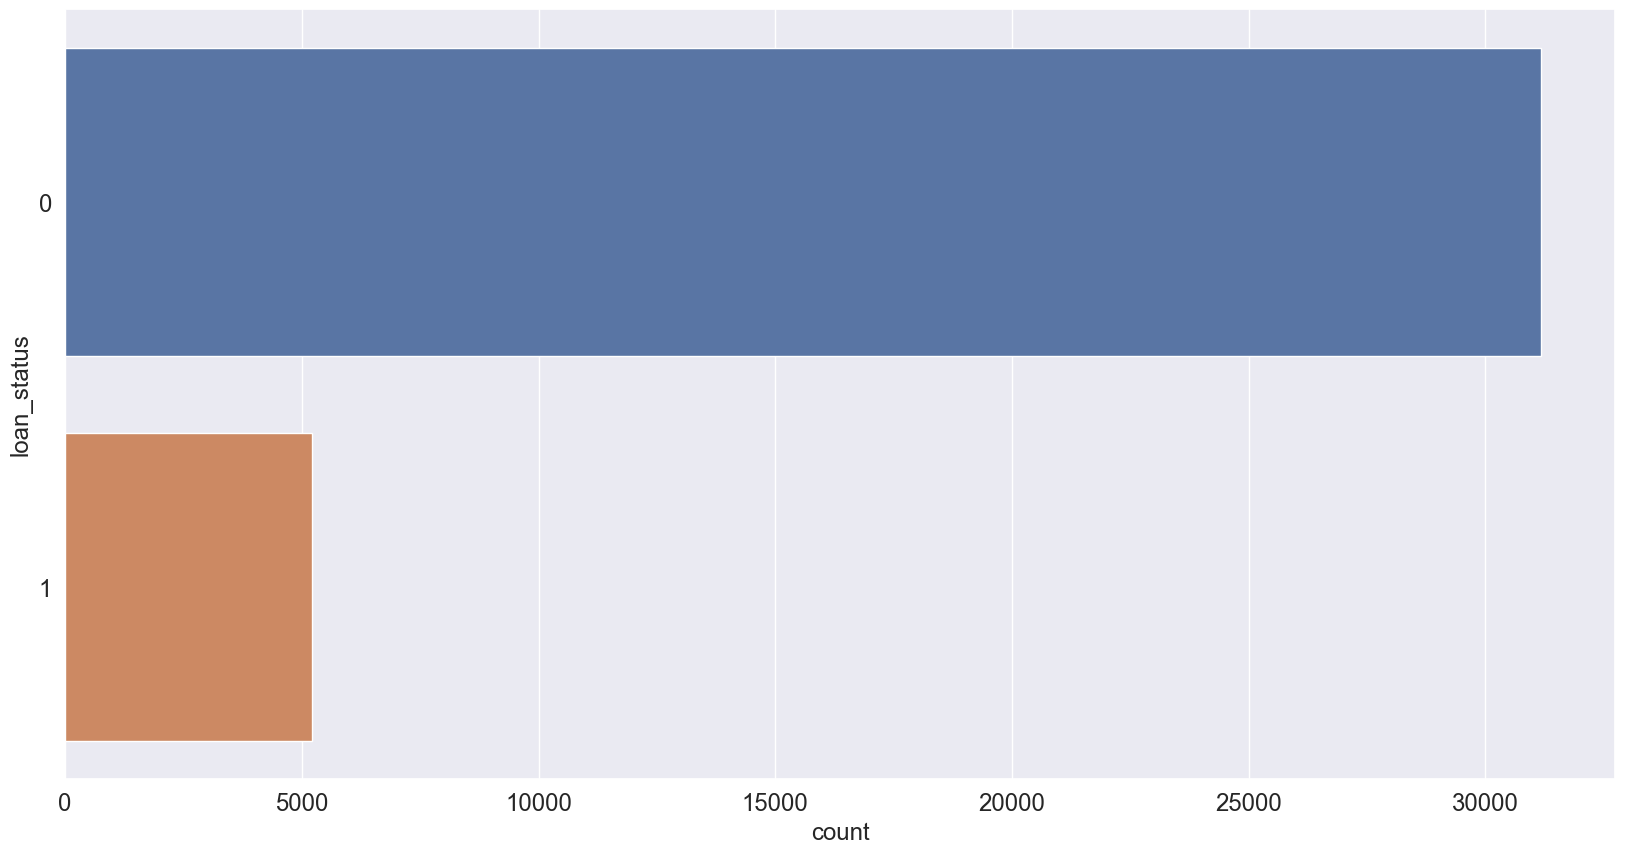

In [22]:
# Check for amount of defaults in the data using countplot
plt.figure()
sns.countplot(y="loan_status", data=df_processed)
plt.show()

### Numerical Features

In [23]:
from validmind.data_validation.metrics import TabularNumericalHistograms
metric = TabularNumericalHistograms(test_context)
metric.run()
metric.result.show()

/Users/juanvalidmind/Dev/github/validmind/validmind-python/validmind/data_validation/metrics.py:285: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


### Categorical Features

In [24]:
from validmind.data_validation.metrics import TabularCategoricalBarPlots
metric = TabularCategoricalBarPlots(test_context)
metric.run()
metric.result.show()

/Users/juanvalidmind/Dev/github/validmind/validmind-python/validmind/data_validation/metrics.py:336: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


### Datetime Features

In [25]:
from validmind.data_validation.metrics import TabularDateTimeHistograms
metric = TabularDateTimeHistograms(test_context)
metric.run()
metric.result.show()

### Loan Defaults Ratio by Feature

In [26]:
from validmind.data_validation.metrics import LoanDefaultRatio

# Select numerical and categorical features 
numerical_features = ['emp_length', 'month', 'year', 'earliest_cr_line', 'inq_last_6mths', 'revol_util', 'total_acc',
                       'loan_amnt_range', 'int_rate_range', 'dti_range', 'installment', 'annual_inc_range']
categorical_features = ['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'open_acc', 'pub_rec']

# Configure the metric
params = {
    "loan_status_col": "loan_status",
    "columns": numerical_features + categorical_features
}

test_context = TestContext(dataset=vm_df)
metric = LoanDefaultRatio(test_context, params=params)
metric.run()
metric.result.show()

The column loan_status is correct and contains only 1 and 0.


## Step 7: Multivariate Analysis

Select variables for multivariate analysis.

In [29]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36388 entries, 0 to 39716
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   loan_amnt                 36388 non-null  int64         
 1   funded_amnt_inv           36388 non-null  float64       
 2   term                      36388 non-null  object        
 3   int_rate                  36388 non-null  float64       
 4   installment               36388 non-null  object        
 5   grade                     36388 non-null  object        
 6   sub_grade                 36388 non-null  object        
 7   emp_length                36388 non-null  float64       
 8   home_ownership            36388 non-null  object        
 9   annual_inc                36388 non-null  float64       
 10  verification_status       36388 non-null  object        
 11  issue_d                   36388 non-null  datetime64[ns]
 12  loan_status       

In [30]:
target_variable = ['loan_status']
selected_features = ['term', 'grade', 'purpose', 'pub_rec',
                      'revol_util', 'funded_amnt_inv', 'int_rate', 
                      'annual_inc_range', 'dti', 'installment',
                      'loan_amnt_range', 'annual_inc', 'loan_amnt',
                      'earliest_cr_line']
df_multivariate = df_processed.loc[:, selected_features + target_variable]

### Bivariate Analysis

**Bar Plots**

In [31]:
def bivariate_barplots(data, variable_pairs):
    for x, hue in variable_pairs.items():
        # Calculate the means
        means = data.groupby([x, hue])['loan_status'].mean().unstack().reset_index()
        hue_categories = means.columns[1:]  # get hue categories

        n = len(hue_categories)  # number of hue categories
        width = 1 / (n + 1)  # width of bars

        plt.figure()

        # Create a color palette
        color_palette = {category: color for category, color in zip(hue_categories, plt.cm.get_cmap('tab10').colors)}

        for i, hue_category in enumerate(hue_categories):
            plt.bar(np.arange(len(means)) + i * width, means[hue_category], color=color_palette[hue_category], 
                    alpha=0.7, label=hue_category, width=width)

        plt.title(x + " by " + hue)
        plt.xlabel(x)
        plt.ylabel("Loan Default Ratio")
        plt.xticks(ticks=np.arange(len(means)), labels=means[x], rotation=90)  # set x-tick labels
        plt.legend()
        plt.show()


/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/3527121114.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = {category: color for category, color in zip(hue_categories, plt.cm.get_cmap('tab10').colors)}


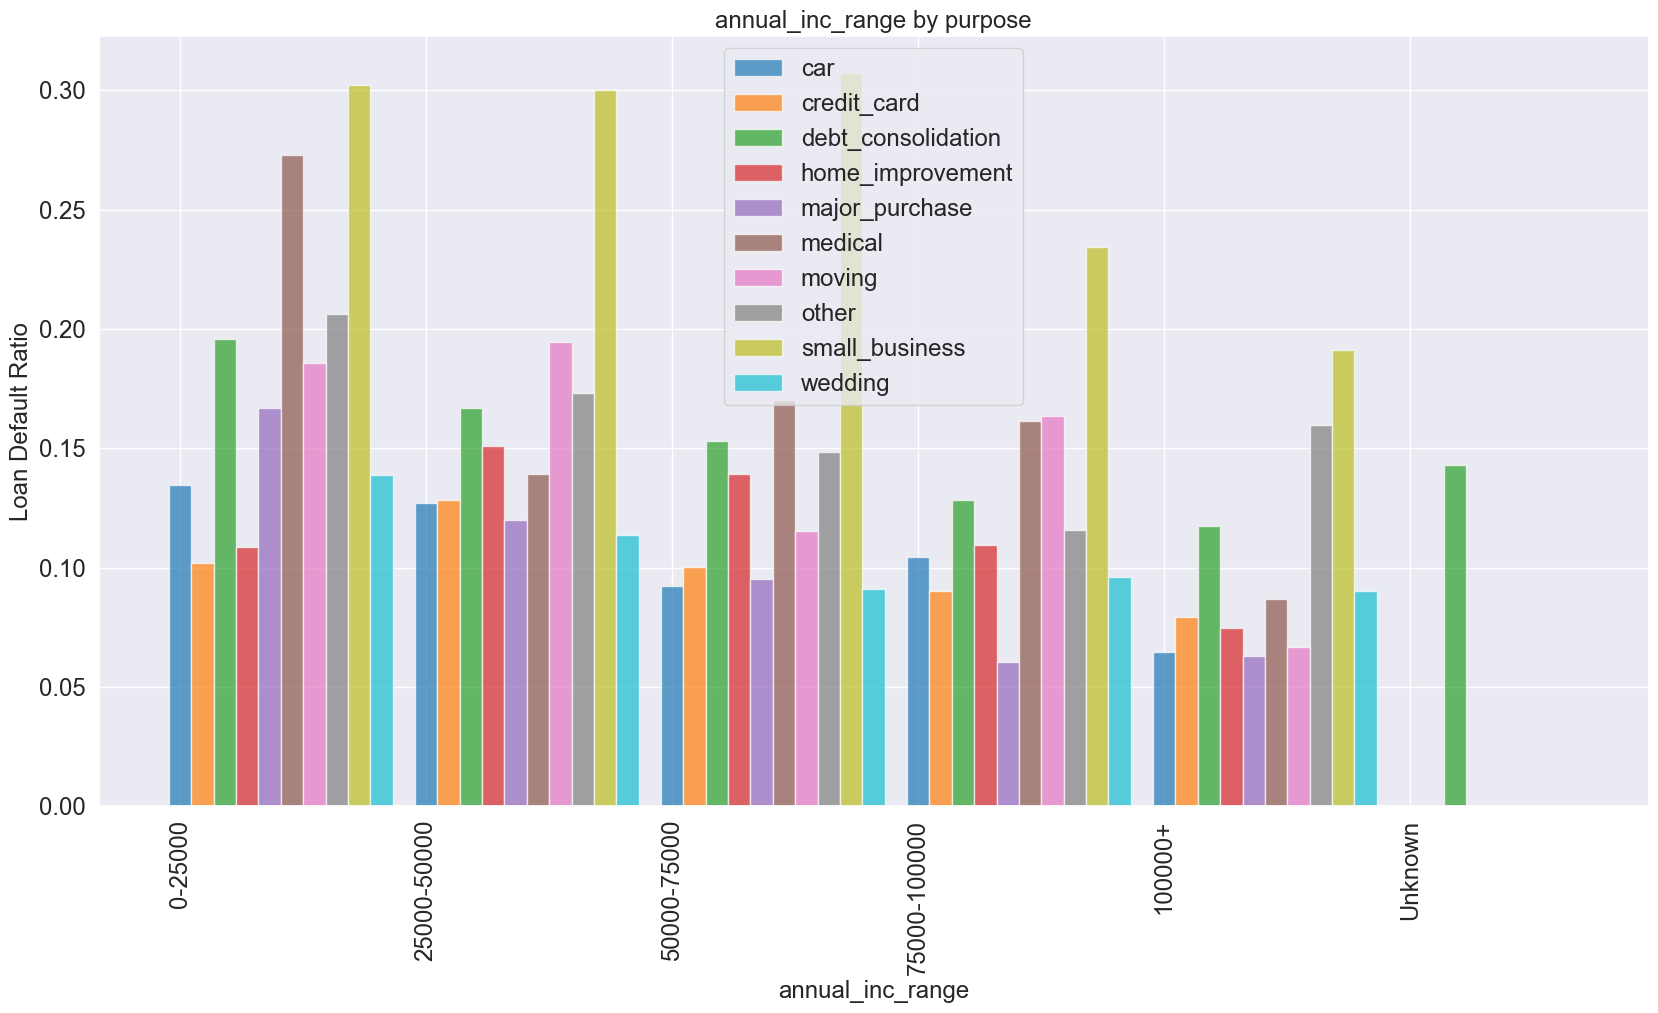

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/3527121114.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = {category: color for category, color in zip(hue_categories, plt.cm.get_cmap('tab10').colors)}


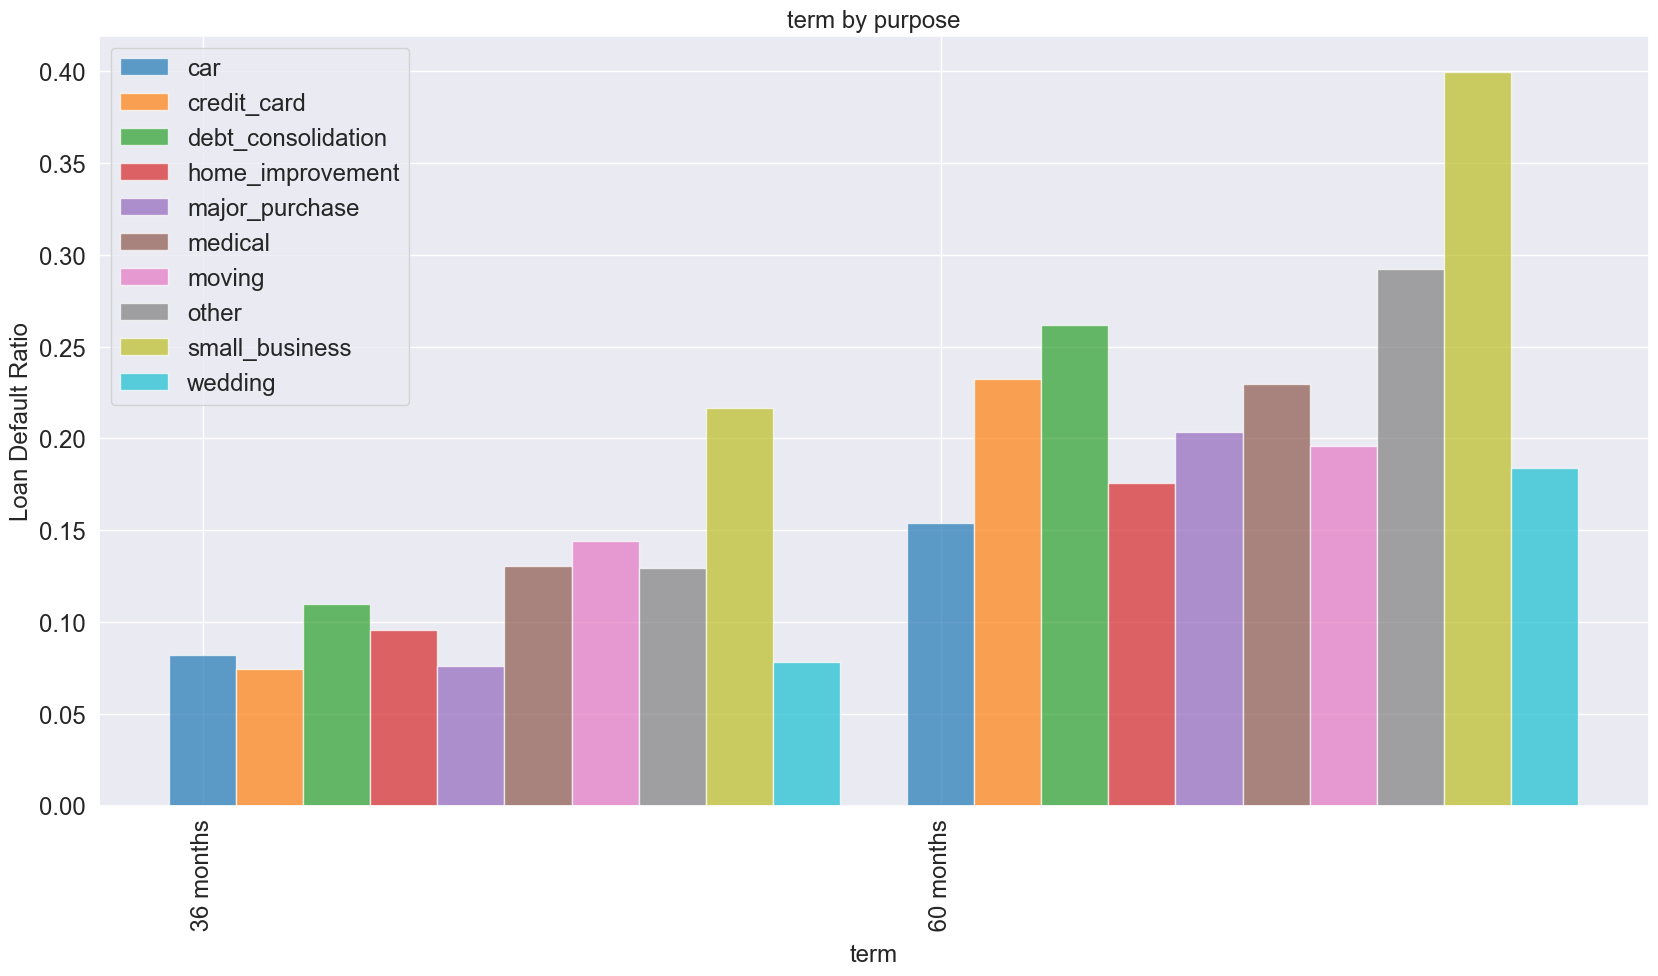

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/3527121114.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = {category: color for category, color in zip(hue_categories, plt.cm.get_cmap('tab10').colors)}


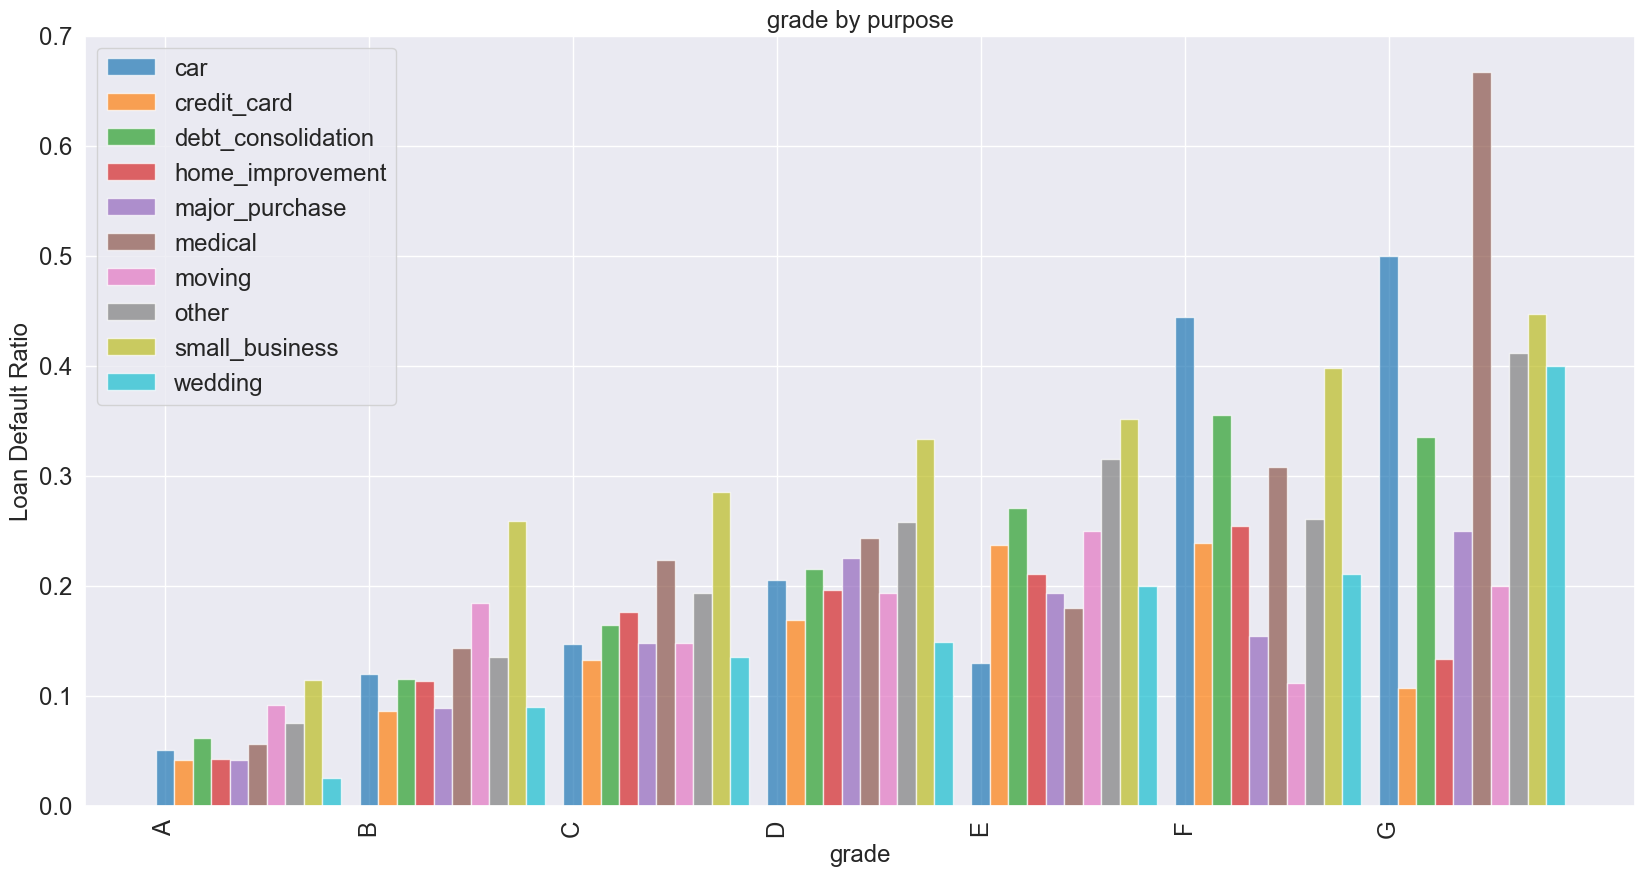

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/3527121114.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = {category: color for category, color in zip(hue_categories, plt.cm.get_cmap('tab10').colors)}


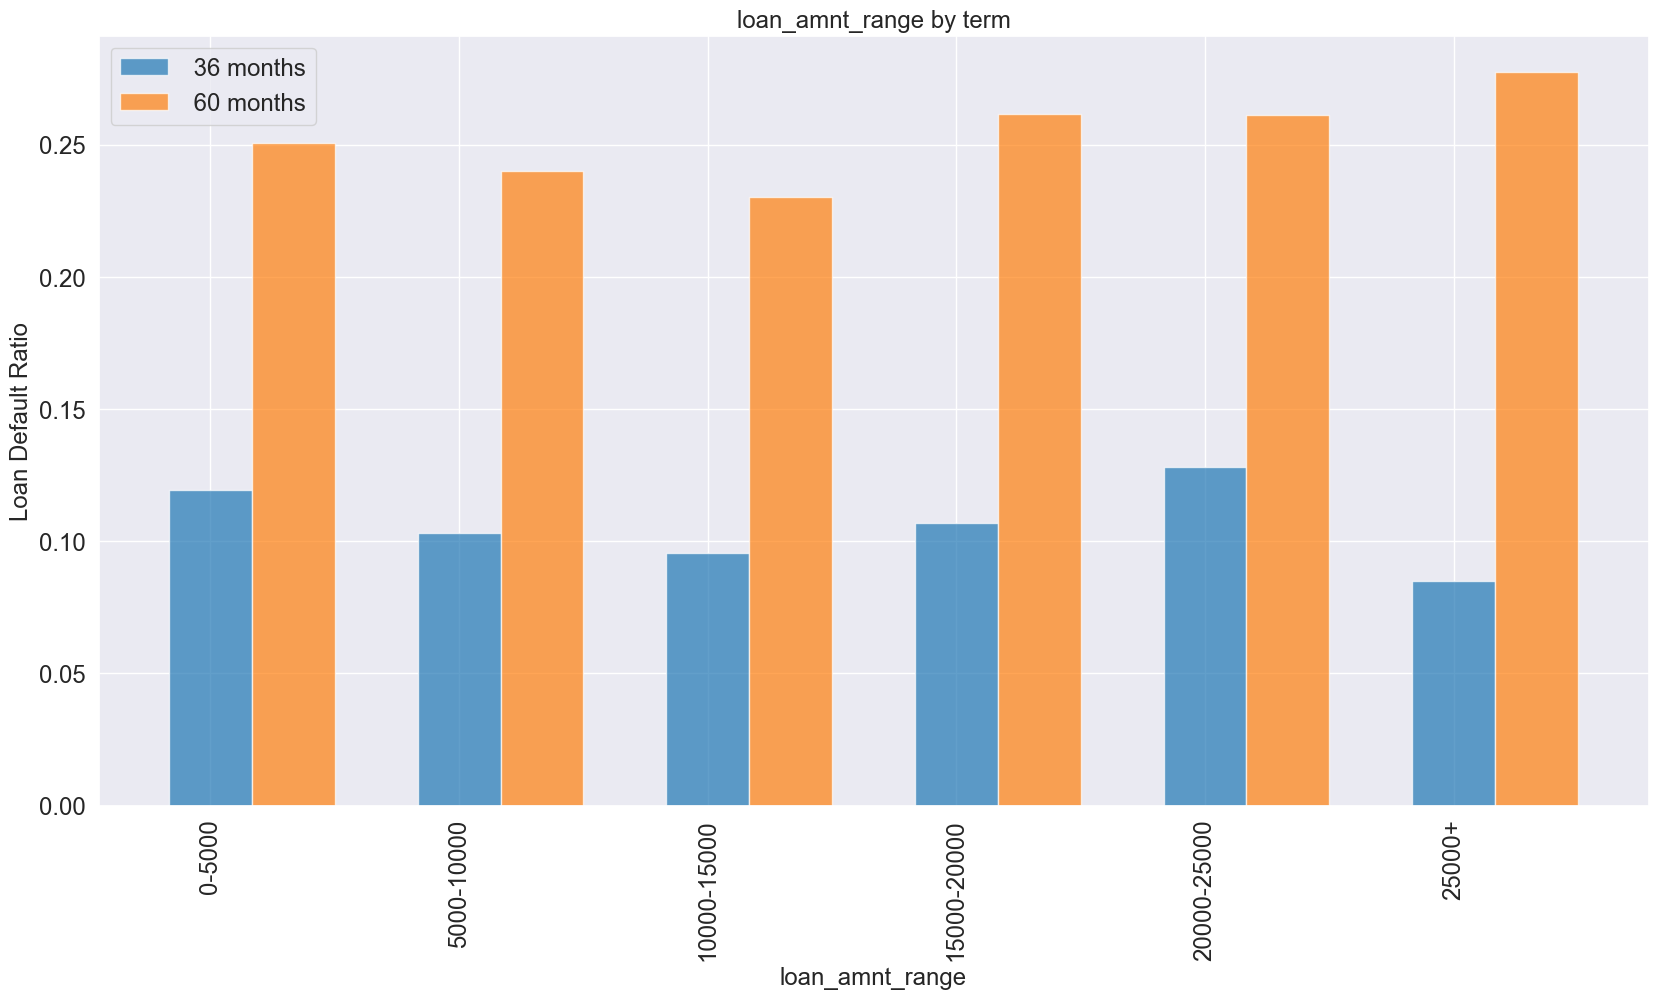

/var/folders/tn/rbr74q892k13m82y37y396h40000gn/T/ipykernel_19384/3527121114.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_palette = {category: color for category, color in zip(hue_categories, plt.cm.get_cmap('tab10').colors)}


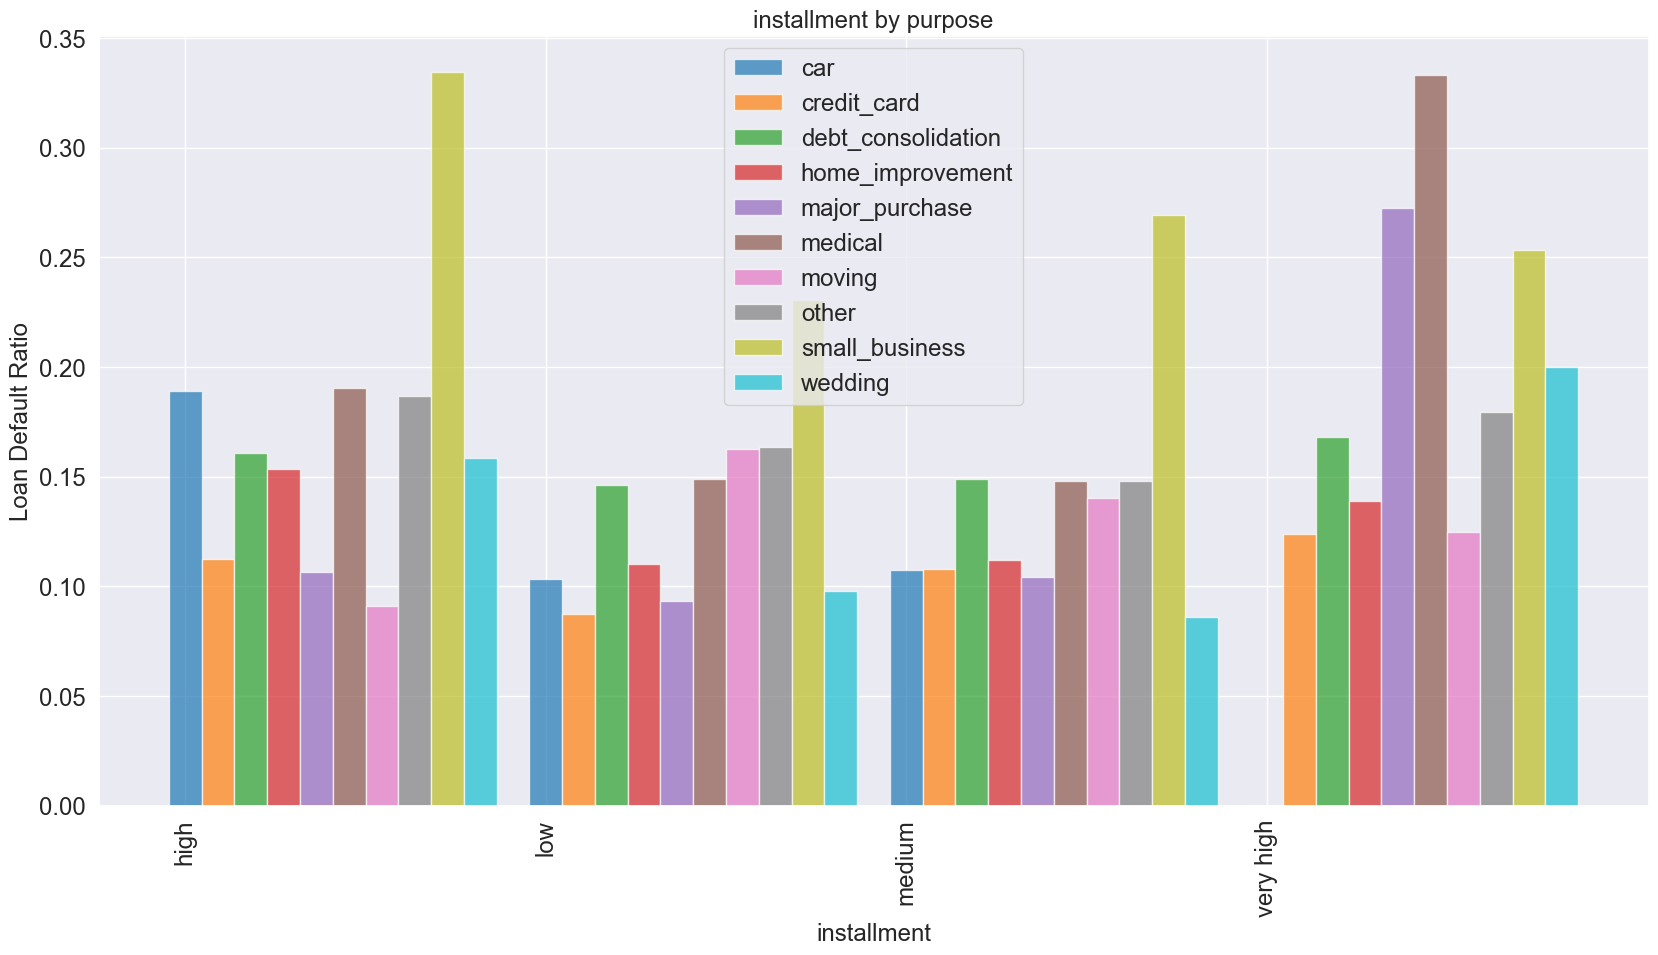

In [32]:
variable_pairs = {'annual_inc_range': 'purpose', 
                  'term': 'purpose', 
                  'grade': 'purpose',
                  'loan_amnt_range': 'purpose',
                  'loan_amnt_range': 'term',
                  'installment': 'purpose'}
bivariate_barplots(df_multivariate, variable_pairs)

**Scatter Plots**

In [33]:
df_multivariate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36388 entries, 0 to 39716
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   term              36388 non-null  object  
 1   grade             36388 non-null  object  
 2   purpose           36388 non-null  object  
 3   pub_rec           36388 non-null  int64   
 4   revol_util        36388 non-null  float64 
 5   funded_amnt_inv   36388 non-null  float64 
 6   int_rate          36388 non-null  float64 
 7   annual_inc_range  36388 non-null  category
 8   dti               36388 non-null  float64 
 9   installment       36388 non-null  object  
 10  loan_amnt_range   36388 non-null  category
 11  annual_inc        36388 non-null  float64 
 12  loan_amnt         36388 non-null  int64   
 13  earliest_cr_line  36388 non-null  int64   
 14  loan_status       36388 non-null  int64   
dtypes: category(2), float64(5), int64(4), object(4)
memory usage: 5.0+ MB


In [63]:

def bivariate_scatterplots(data, variable_pairs, loan_status_filter=None):
    if loan_status_filter is not None:
        # Apply the filter if it is specified
        data = data[data['loan_status'] == loan_status_filter]
        
    for x, y in variable_pairs.items():
        plt.figure()
        
        # Scatterplot using seaborn, with color variation based on 'loan_status'
        # Create color mapping with rgba values, last value is alpha (transparency)
        palette = {0: (0.8, 0.8, 0.8, 0.8), 1: 'tab:red'}
        plot = sns.scatterplot(data=data, x=x, y=y, hue='loan_status', palette=palette, alpha=1) # set alpha to 1, transparency is managed by the color specification
        
        # Change legend labels
        legend_labels = ['Default' if t.get_text()=='1' else 'Non-default' for t in plot.legend_.texts[1:]]  # Ignore the first text, which is "loan_status"
        plot.legend_.texts[1:] = legend_labels

        plt.title(x + " and " + y)
        plt.xlabel(x)
        plt.ylabel(y)
        plt.show()


/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


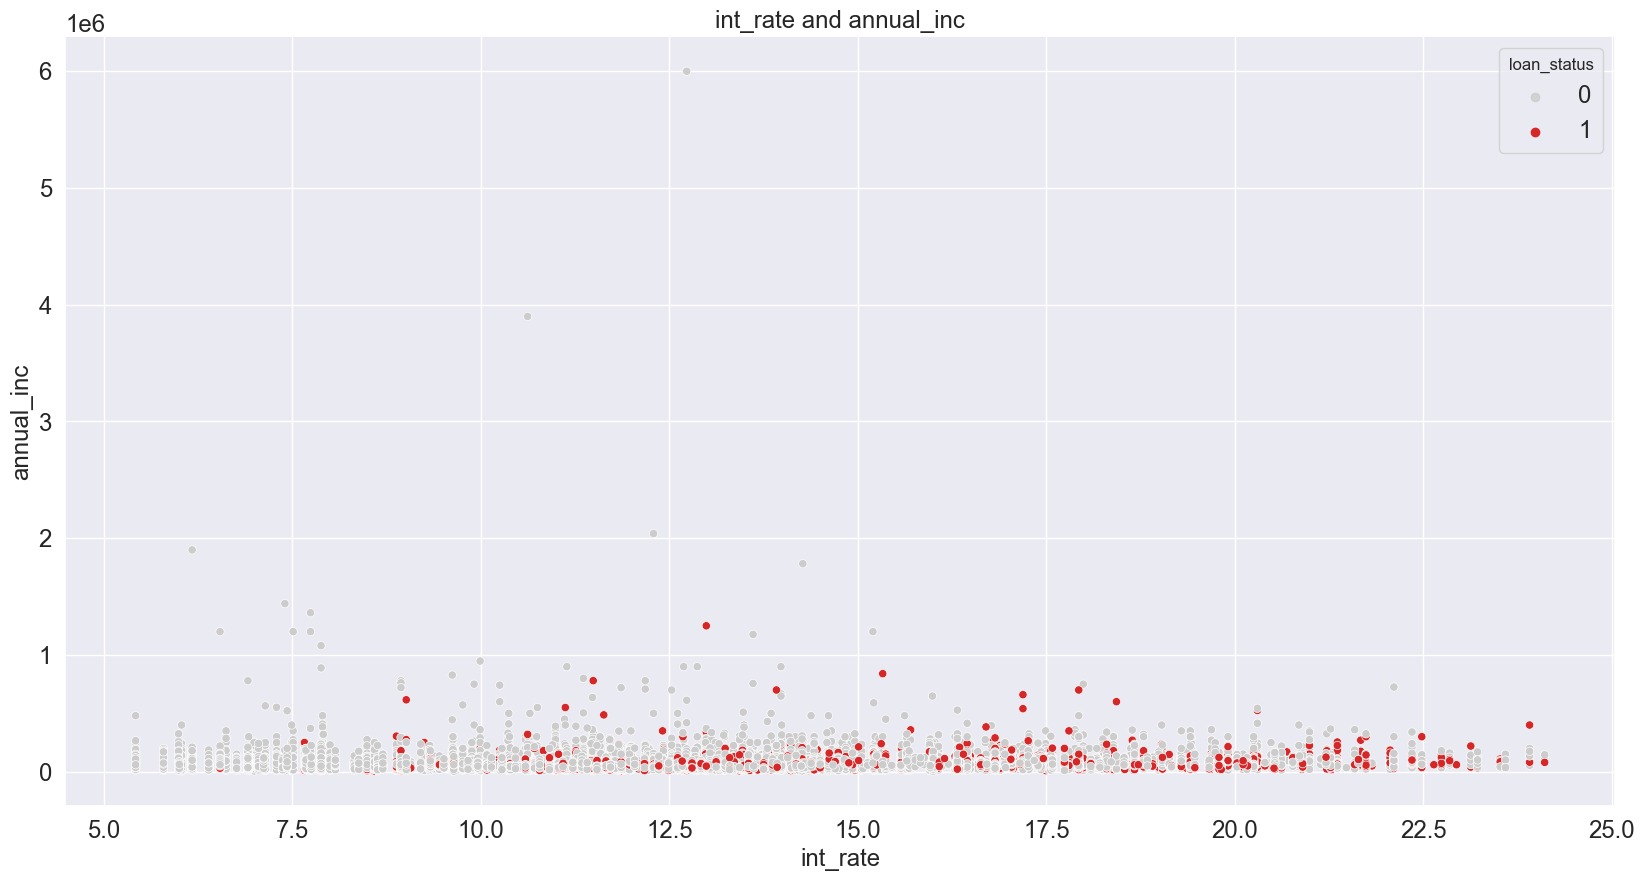

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


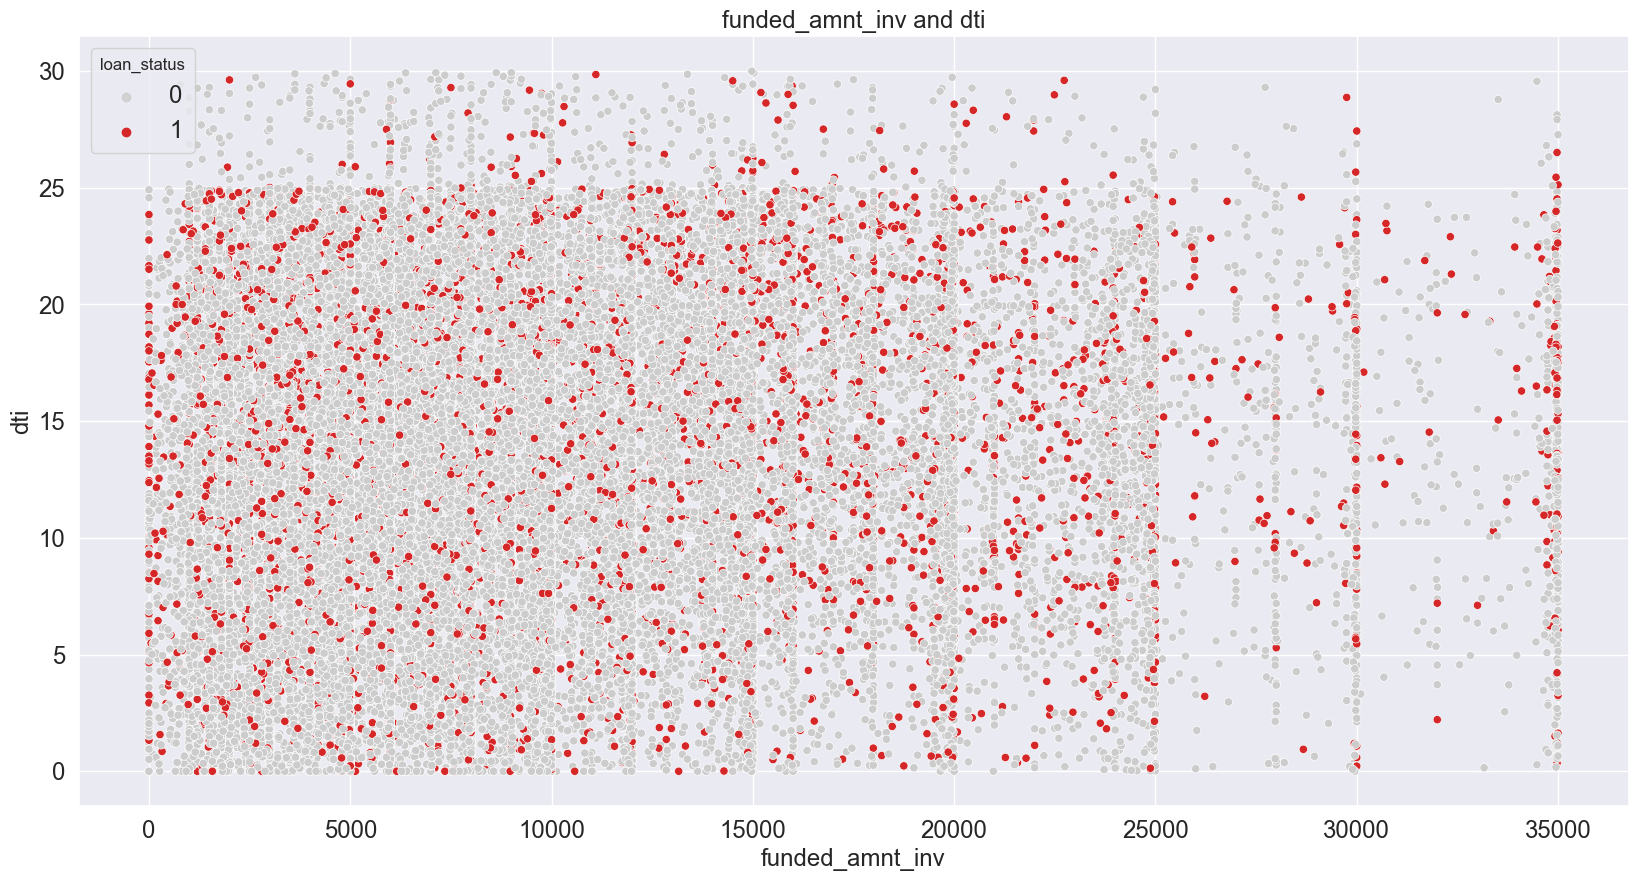

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


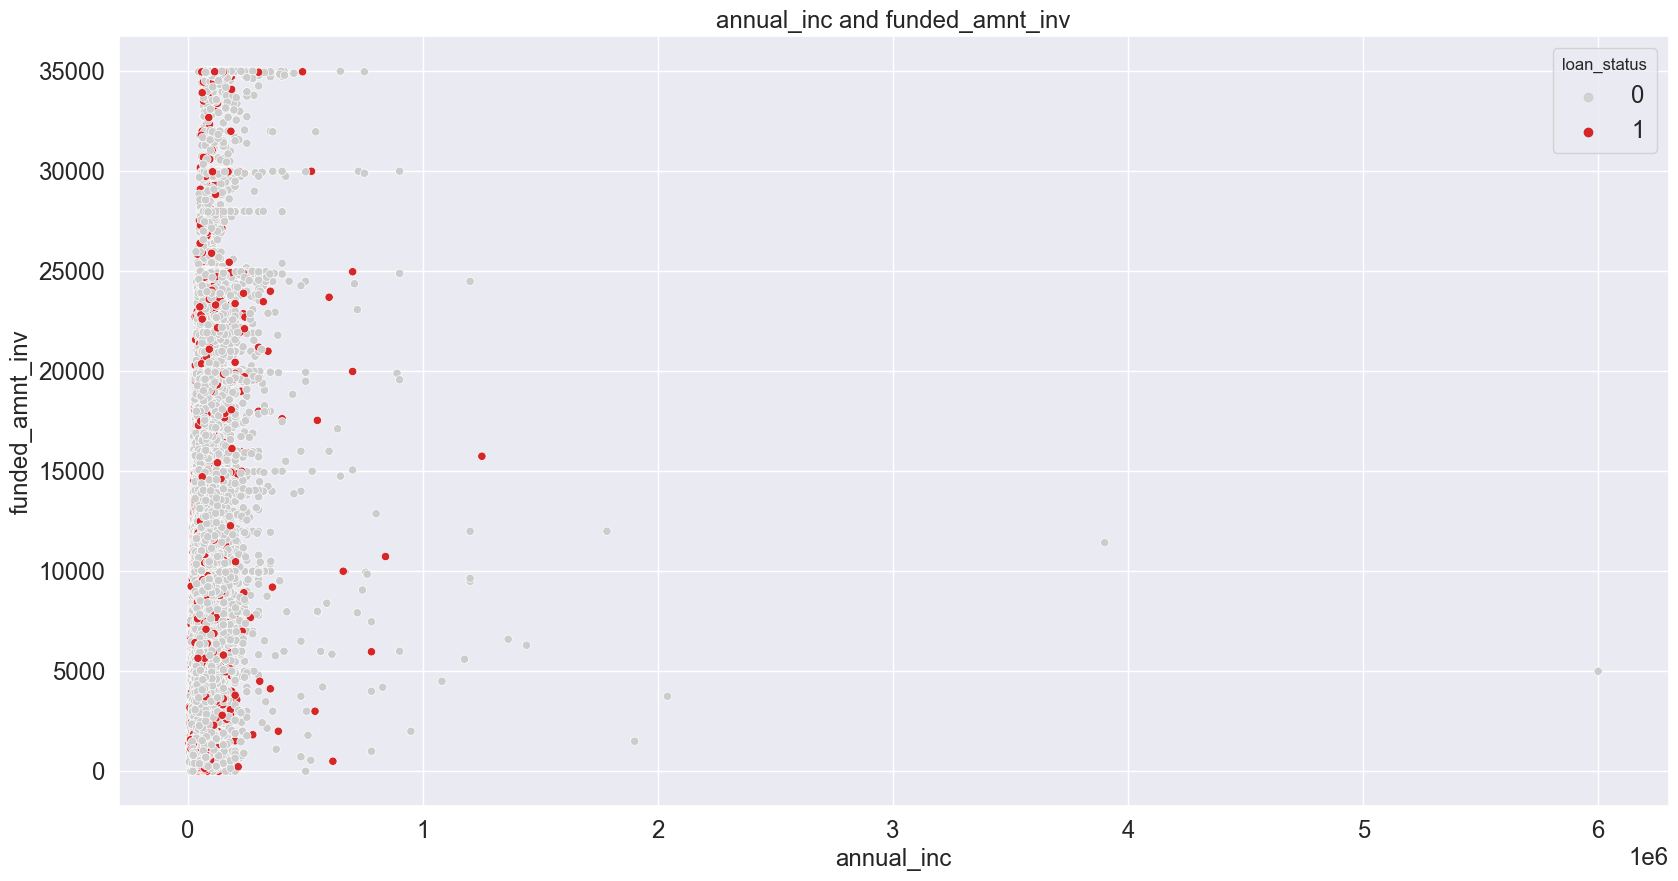

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


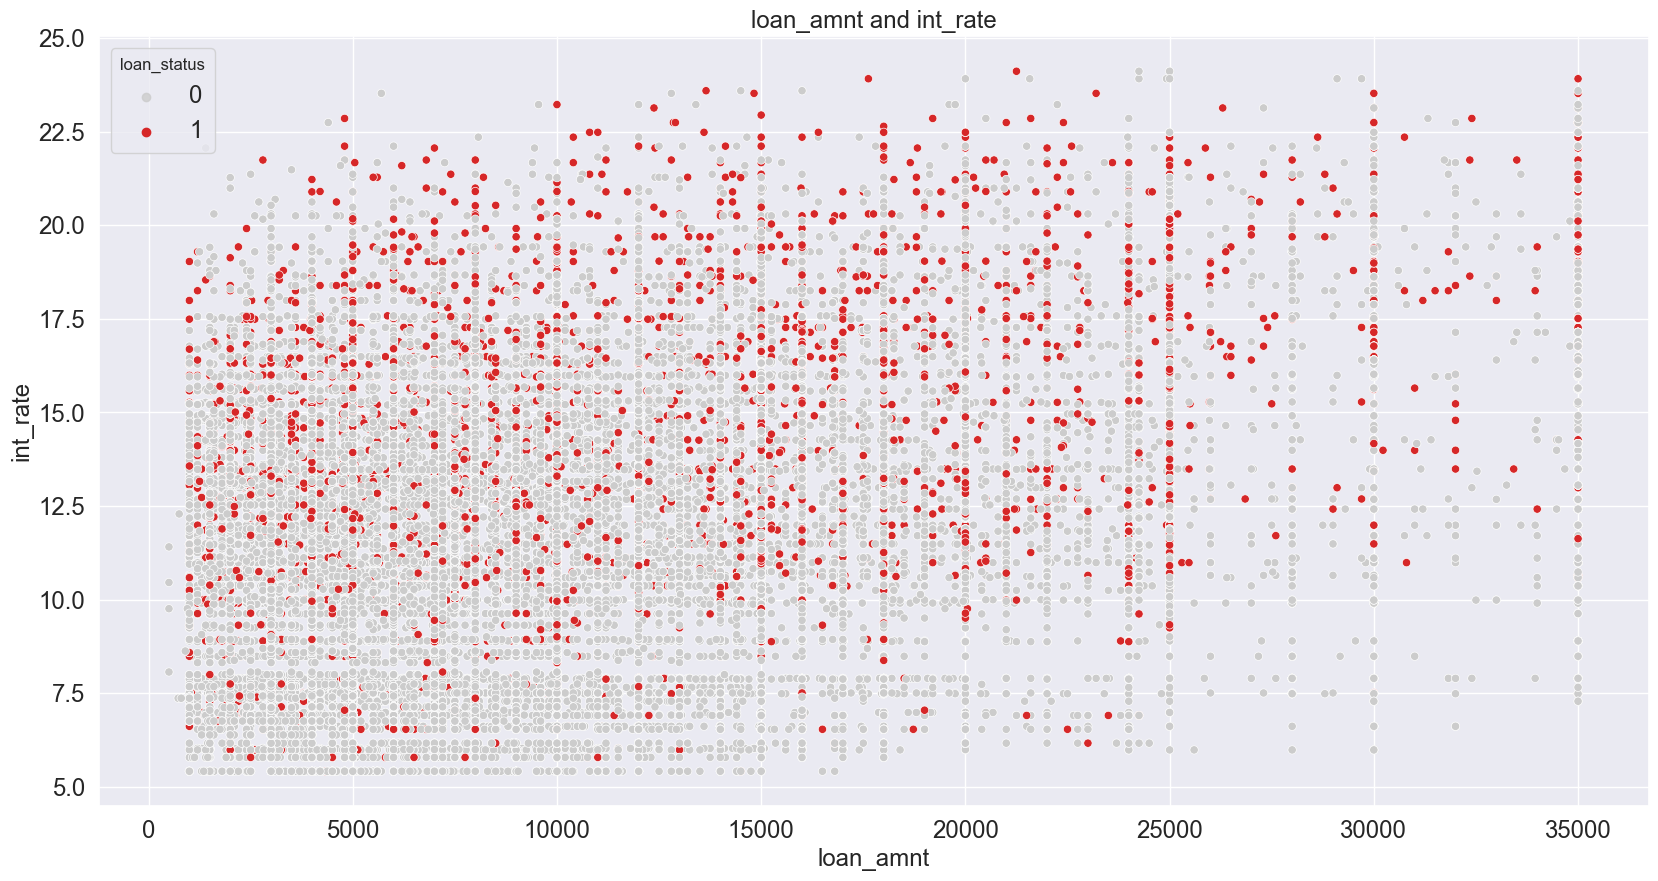

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/relational.py:657: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  args = np.asarray(x), np.asarray(y), np.asarray(s), np.asarray(c)


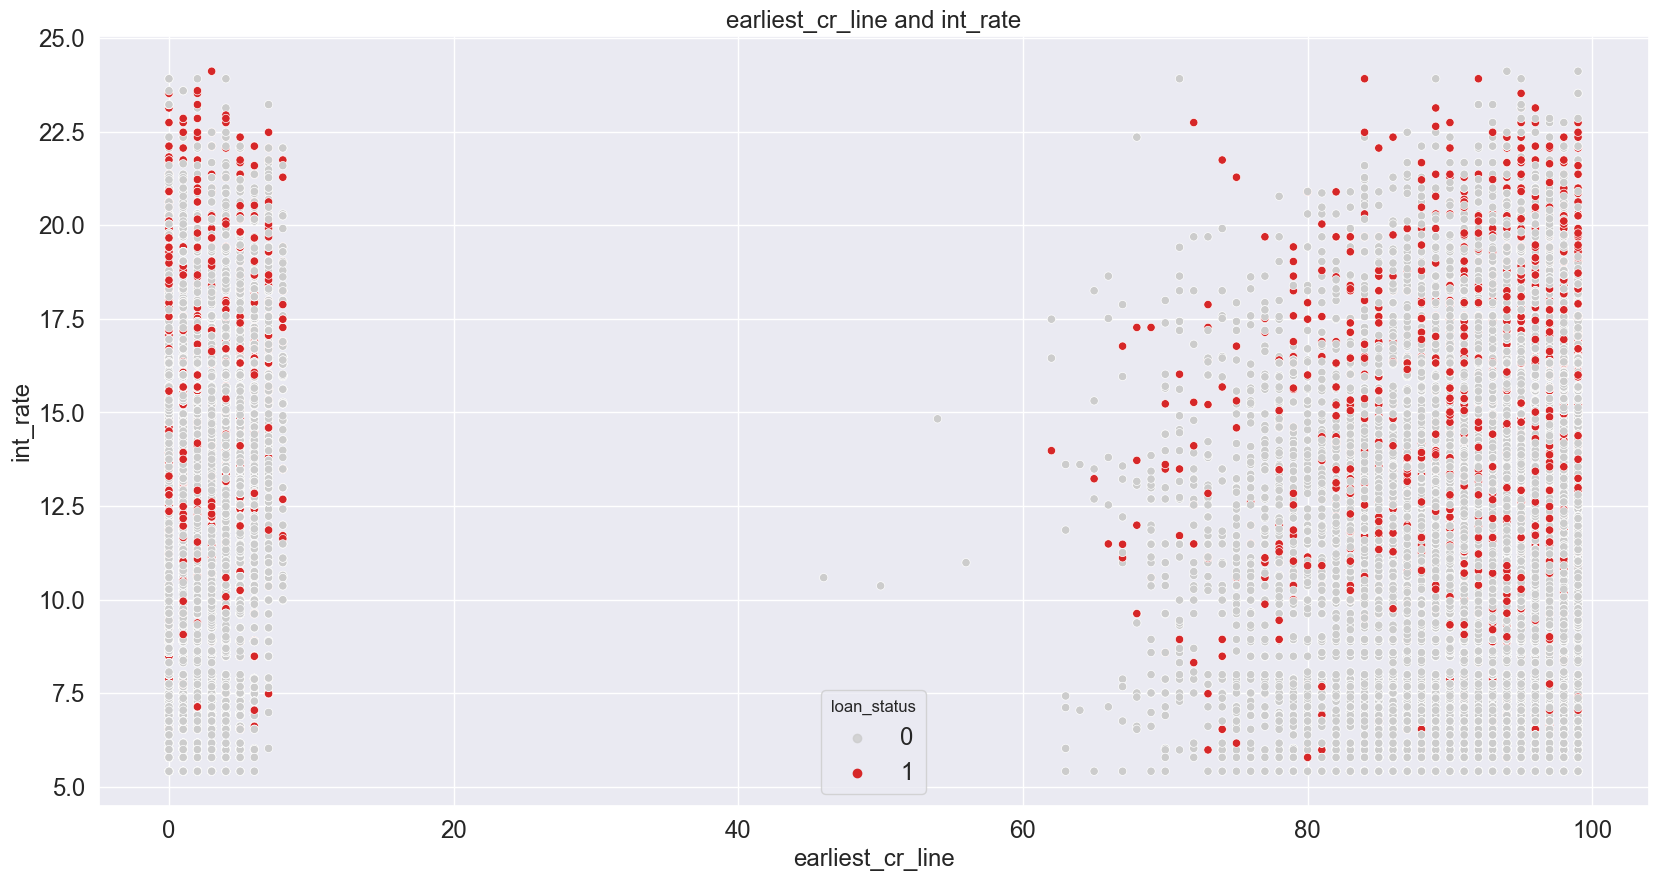

In [64]:
variable_pairs = {'int_rate': 'annual_inc', 
                  'funded_amnt_inv': 'dti', 
                  'annual_inc': 'funded_amnt_inv',
                  'loan_amnt': 'int_rate',
                  'int_rate': 'annual_inc',
                  'earliest_cr_line': 'int_rate'}
bivariate_scatterplots(df_multivariate, variable_pairs, loan_status_filter=None)

**Bivariate Histograms**

In [67]:
def bivariate_histograms(data, variable_pairs, loan_status_filter=None):
    if loan_status_filter is not None:
        # Apply the filter if it is specified
        data = data[data['loan_status'] == loan_status_filter]

    # Create color mapping with rgba values, last value is alpha (transparency)
    palette = {0: (0.5, 0.5, 0.5, 0.8), 1: 'tab:red'}

    for x, y in variable_pairs.items():
        fig, axes = plt.subplots(2, 1,)

        for ax, var in zip(axes, [x, y]):
            for loan_status, color in palette.items():
                subset = data[data['loan_status'] == loan_status]
                sns.histplot(subset[var], ax=ax, color=color, kde=False, label='Default' if loan_status else 'Non-default')
            
            ax.set_title(f"Histogram of {var} by loan status")
            ax.set_xlabel(var)
            ax.legend()

        plt.tight_layout()
        plt.show()


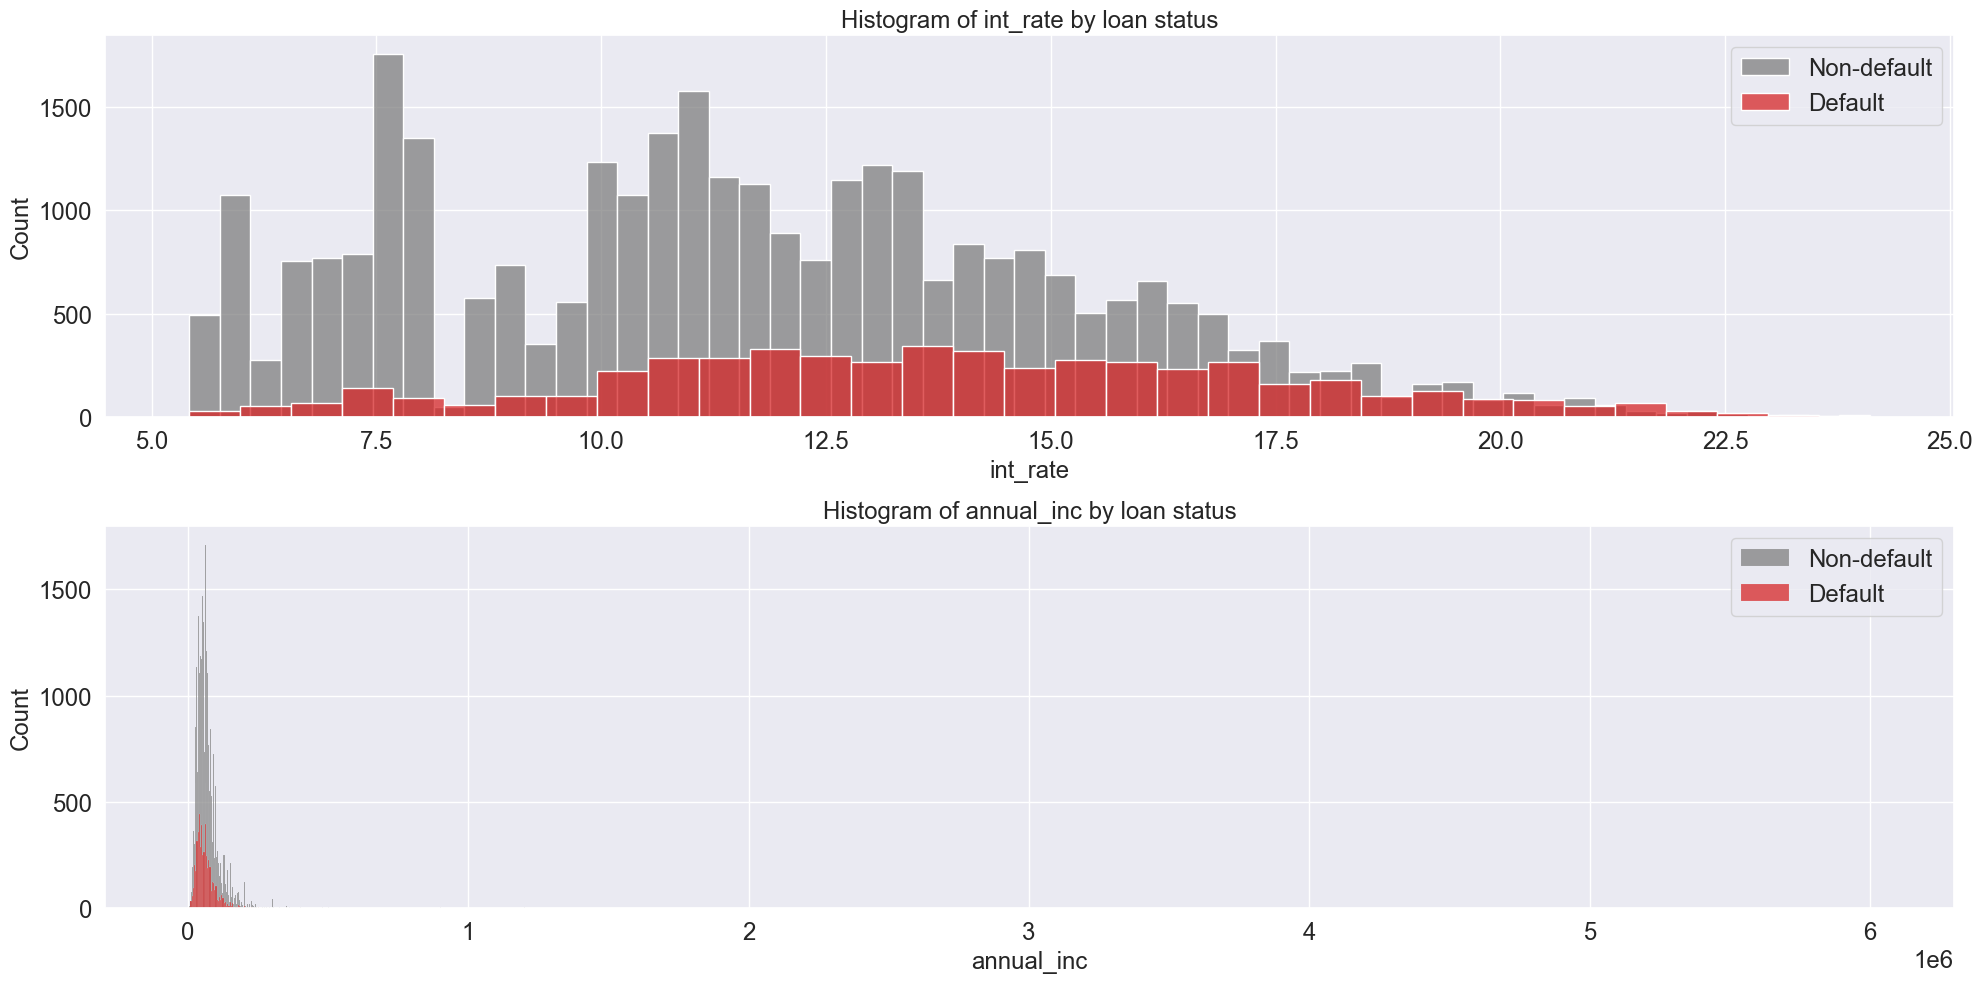

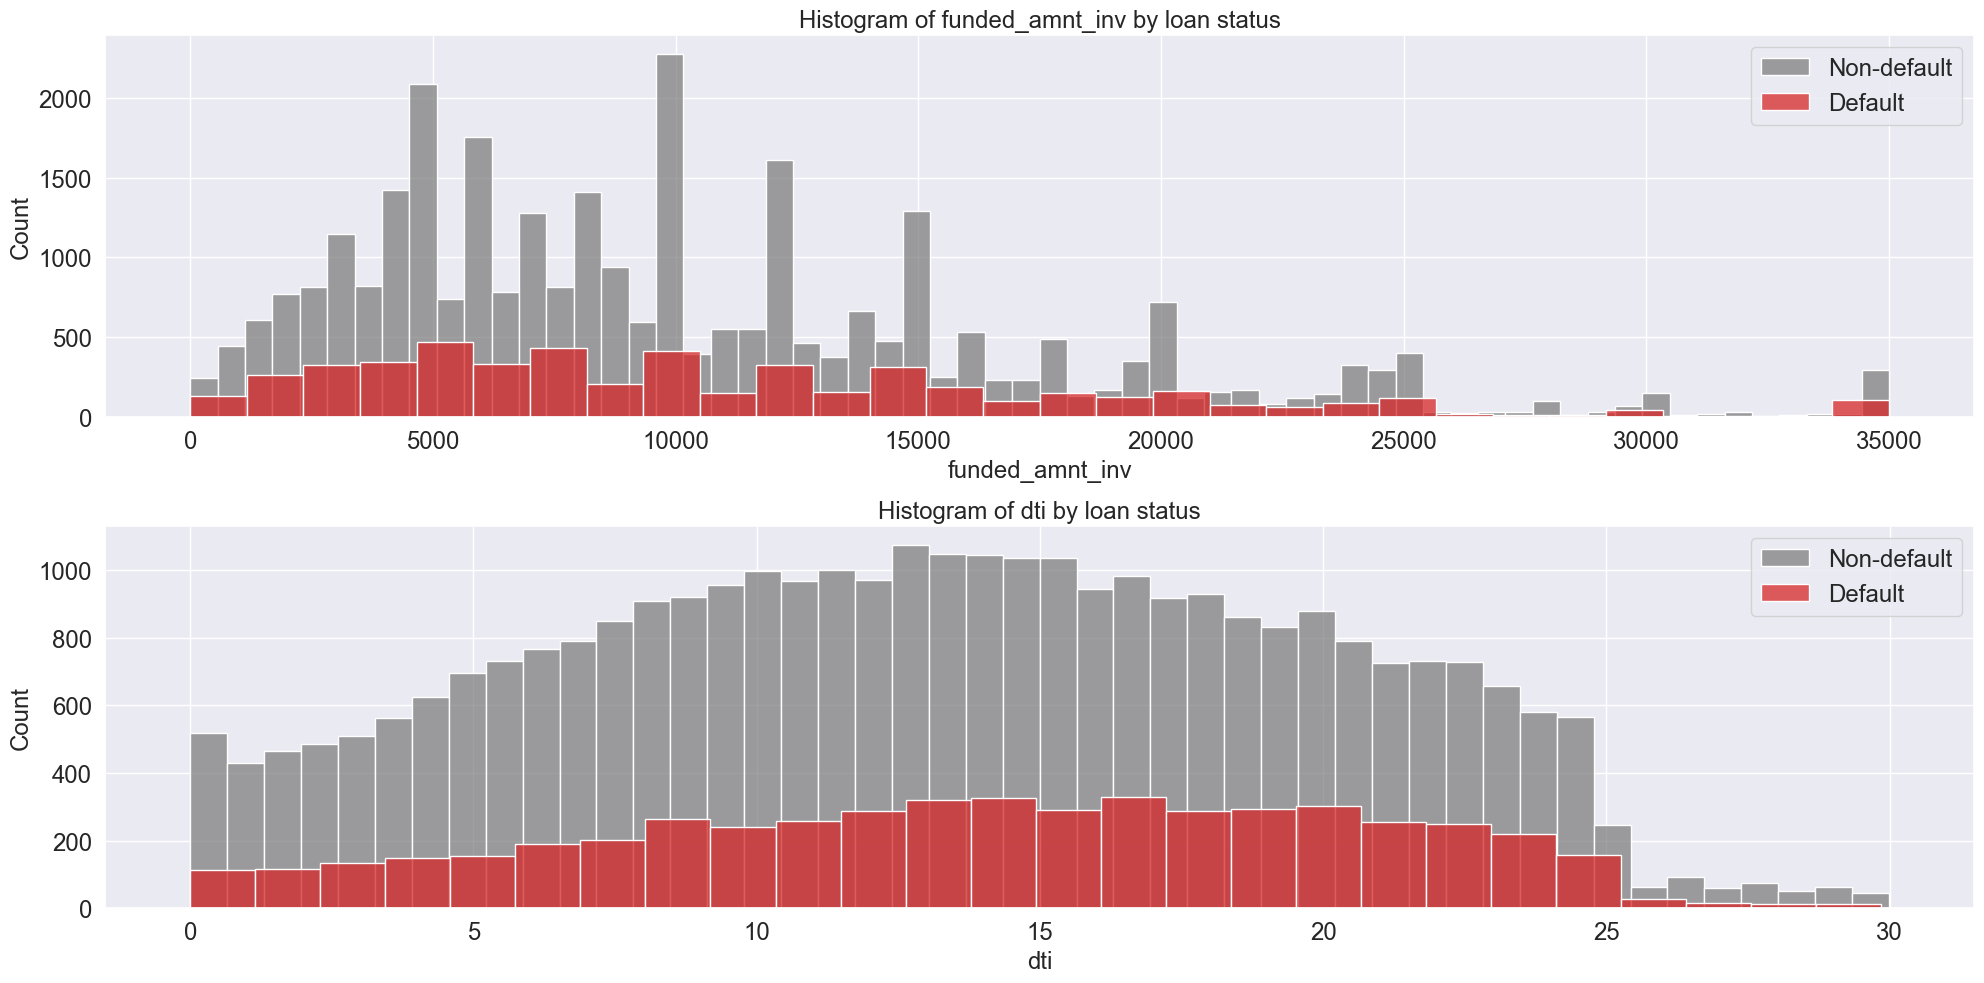

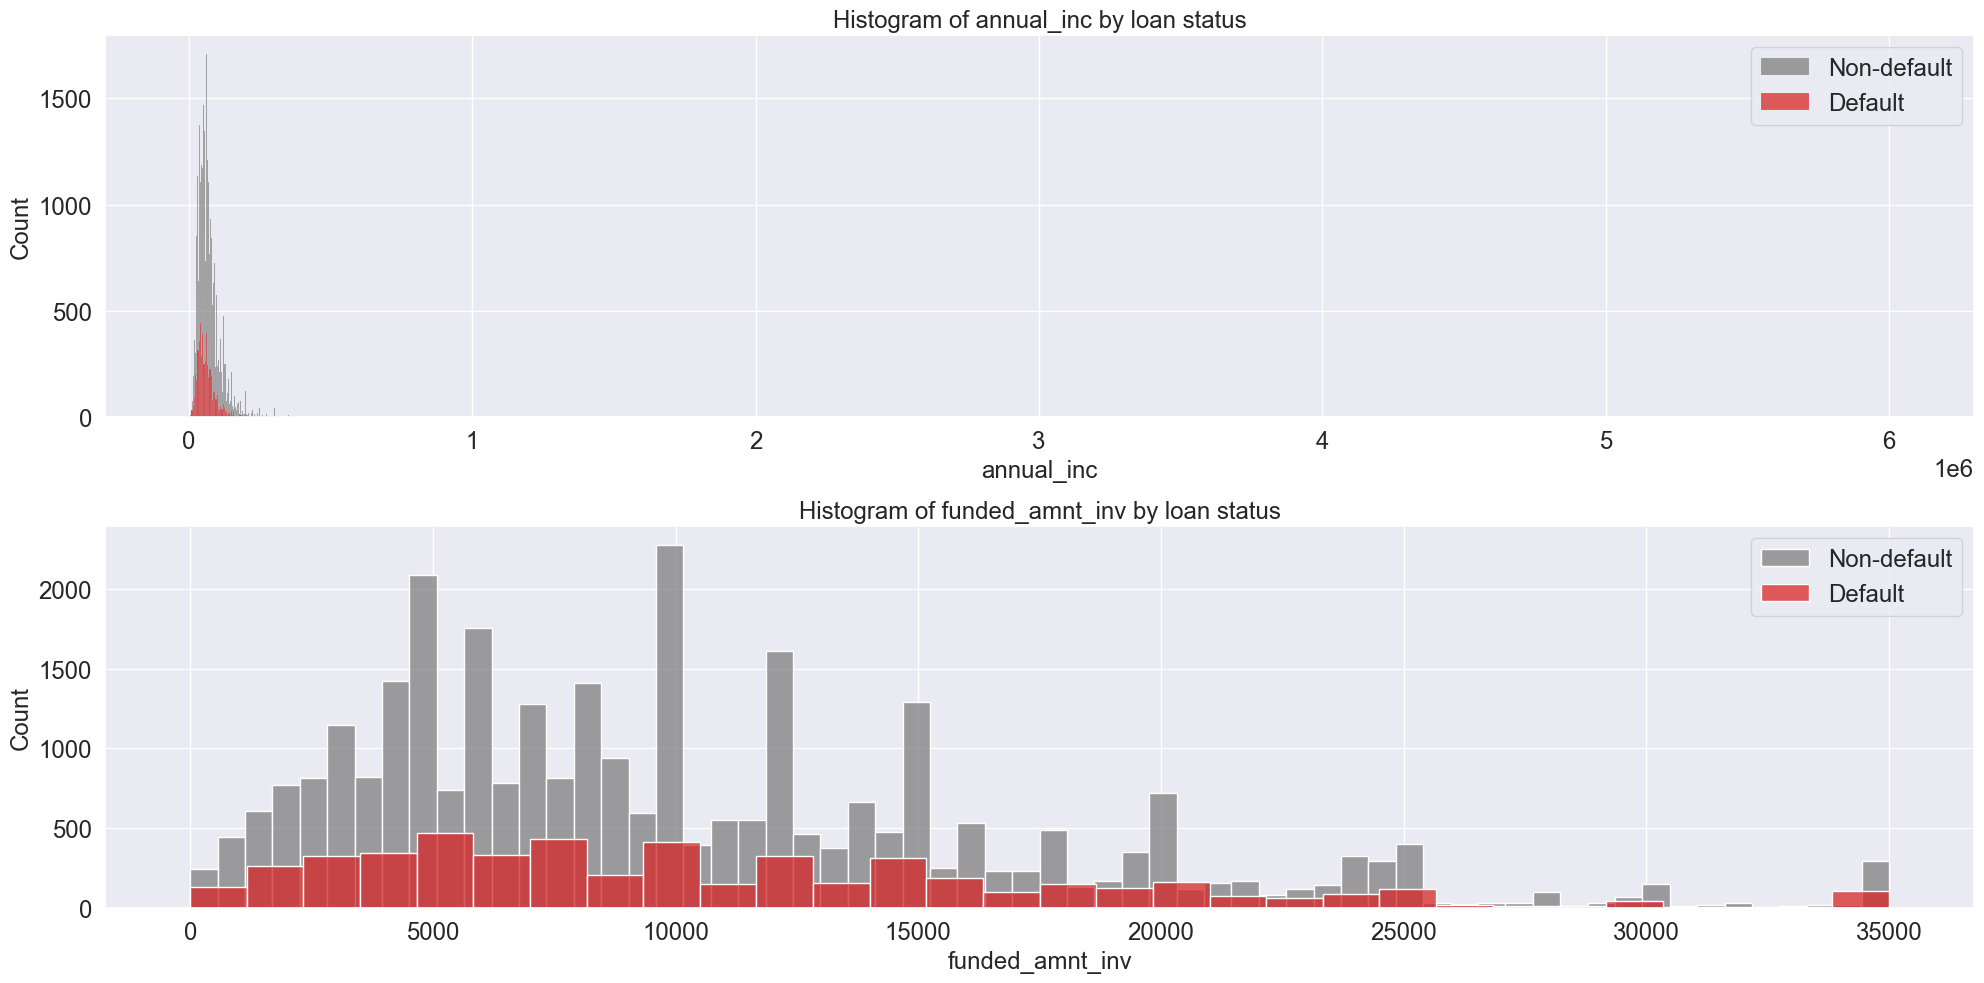

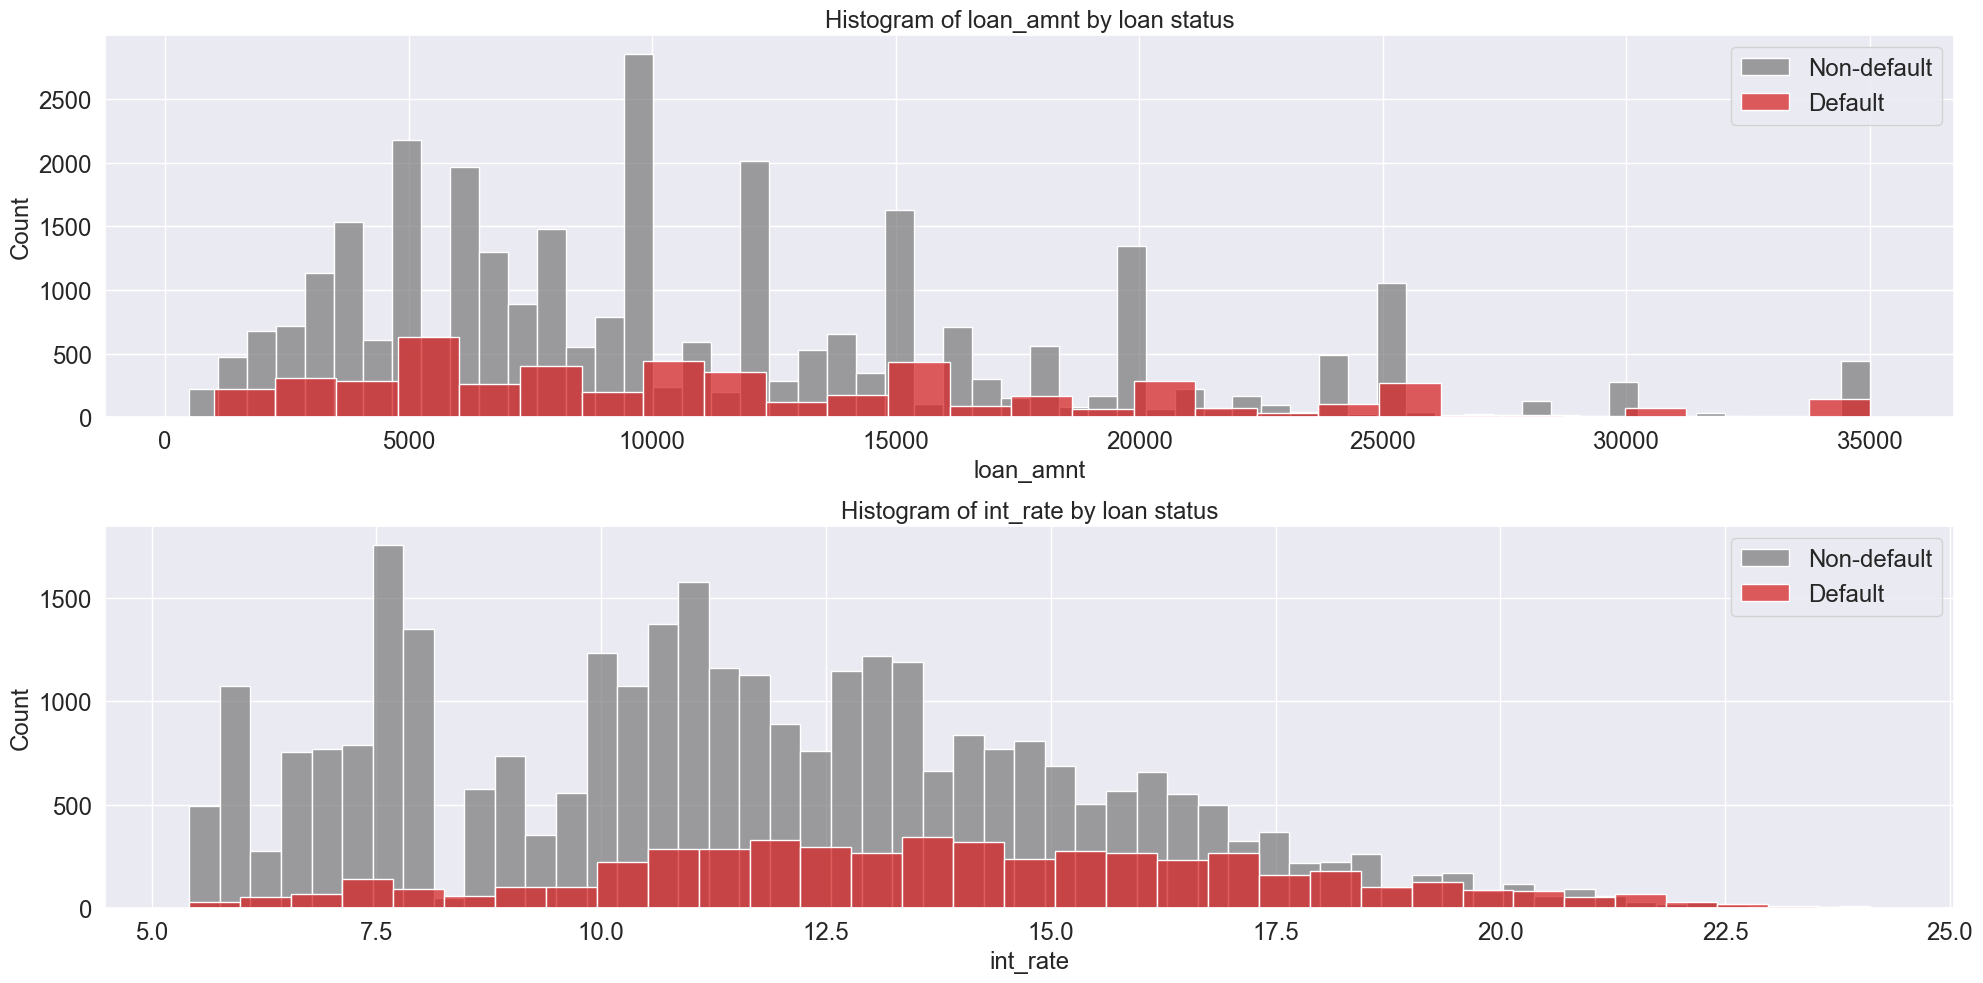

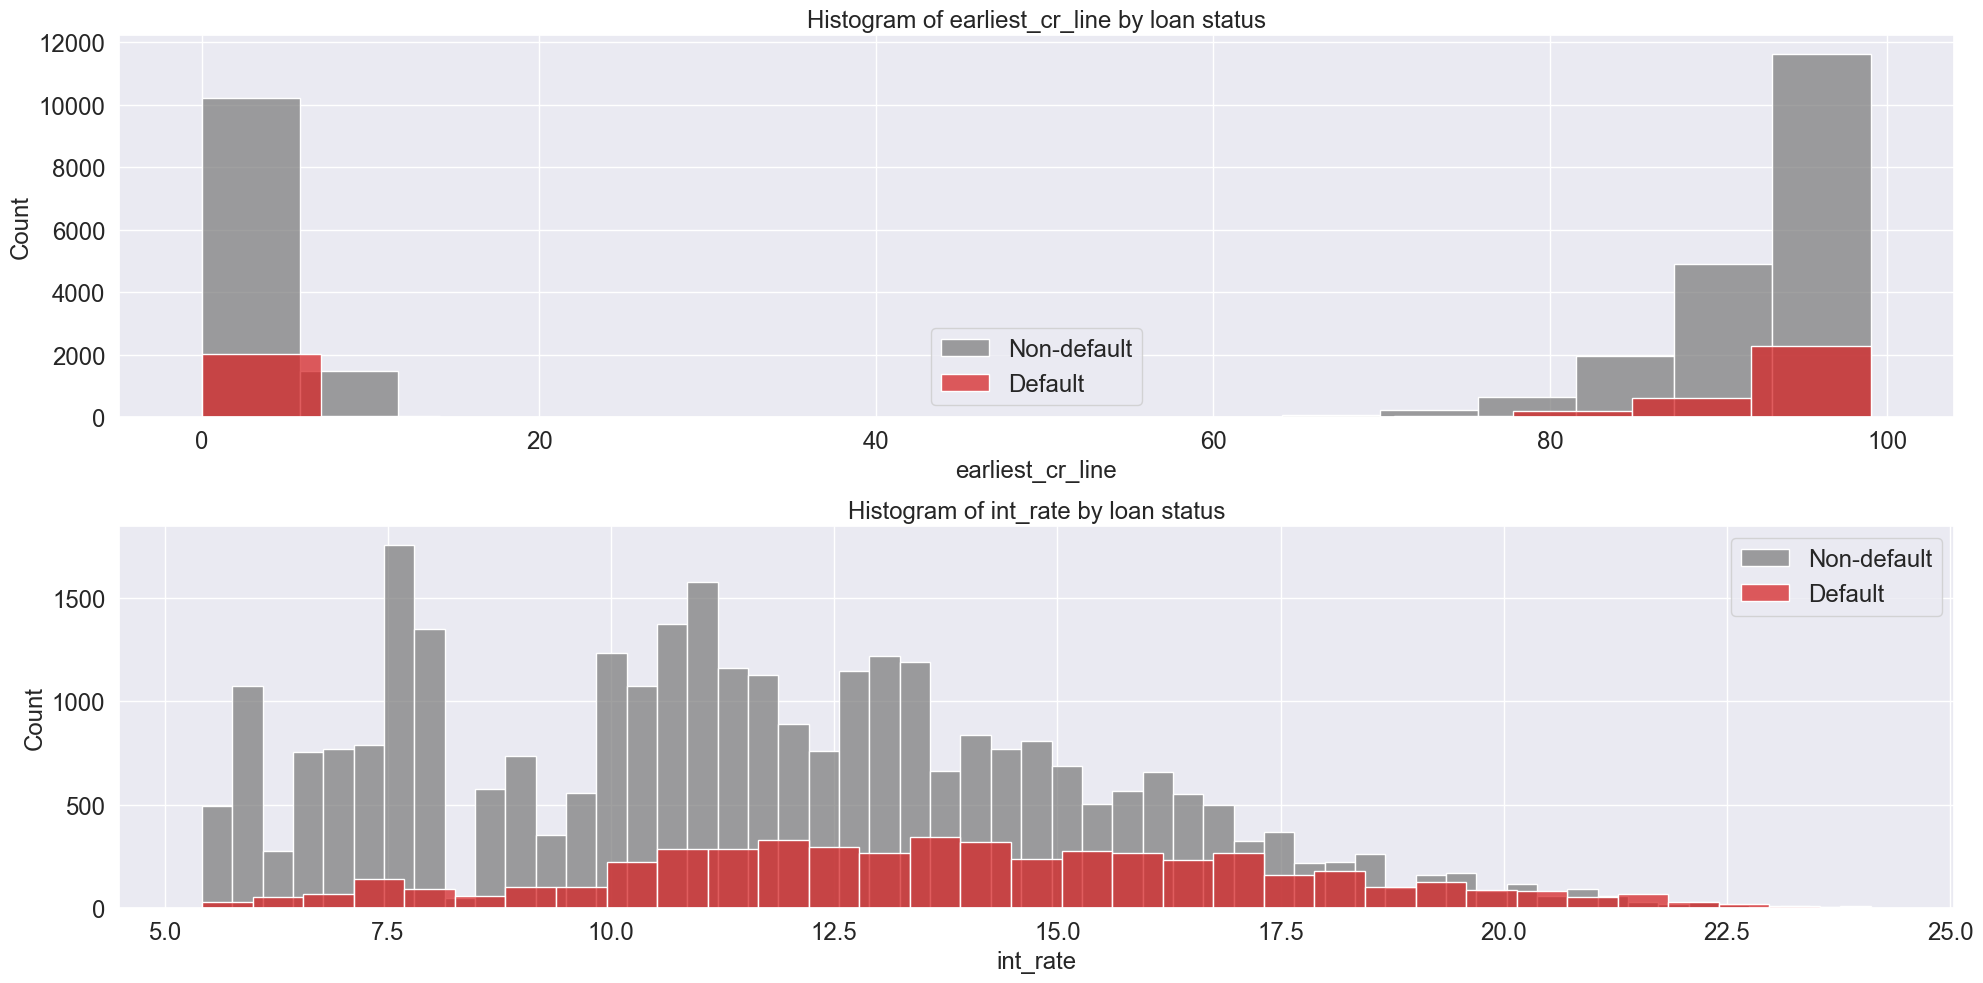

In [68]:
variable_pairs = {'int_rate': 'annual_inc', 
                  'funded_amnt_inv': 'dti', 
                  'annual_inc': 'funded_amnt_inv',
                  'loan_amnt': 'int_rate',
                  'int_rate': 'annual_inc',
                  'earliest_cr_line': 'int_rate'}
bivariate_histograms(df_multivariate, variable_pairs, loan_status_filter=None)